<a href="https://colab.research.google.com/github/meeraks1234/Dida/blob/main/dida_unet_with_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Satellite Pictures Image Segmentation

### As the training dataset contained a limited number of images, I employed data augmentation techniques  such as rotation, flipping, and scaling and so each image and its mask is augmented to create additional 30 images.
### I employed the U-Net model for performing image segmentation because U-Net model allows for both high-level and low-level feature extraction and is capable of producing segmentation masks with a high level of accuracy.
### Also I employed an attention mechanism along with the U-Net model that allows the model to focus on specific parts of the input data and help the model to identify and focus on important features of the image that are relevant for accurate segmentation, while ignoring irrelevant or noisy features.The input to the attention gate will be the skip conection from encoder stages along with the precious decoder input.






In [ ]:
# Common
import os
import keras
import numpy as np
from glob import glob
from tqdm import tqdm 
import tensorflow as tf

# Data 
from tensorflow.image import resize
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import load_img

# Data visualization
import matplotlib.pyplot as plt

# Model 
from keras import Sequential
from keras.layers import add
from keras.layers import ReLU
from keras.layers import Input
from keras.layers import Layer
from keras.layers import Conv2D 
from keras.layers import Dropout
from keras.layers import multiply
from keras.layers import MaxPool2D
from keras.layers import LeakyReLU
from keras.layers import concatenate
from keras.layers import UpSampling2D
from keras.layers import Conv2DTranspose
from keras.layers import BatchNormalization
from keras.models import Model, load_model

# Model visualization
from tensorflow.keras.utils import plot_model

# Callback
from keras.callbacks import Callback, ModelCheckpoint
    
 #OpenCV       
import cv2
import random
from keras.models import load_model

# Data Augmentation

In [ ]:
#Data augmentation

# define the paths to your original images and masks
img_path = r'/content/drive/MyDrive/dida_test_task/images'
mask_path = r'/content/drive/MyDrive/dida_test_task/labels'

# define the paths to save the augmented images and masks
aug_img_path = r'/content/drive/MyDrive/dida_test_task/augmented_images'
aug_mask_path = r'/content/drive/MyDrive/dida_test_task/augmented_masks'

# make the directories to save the augmented images and masks
if not os.path.exists(aug_img_path):
    os.makedirs(aug_img_path)
if not os.path.exists(aug_mask_path):
    os.makedirs(aug_mask_path)

# define the number of augmented images you want to generate
num_augmented_images = 30

# loop through each image in the original dataset
for i, file_name in enumerate(os.listdir(img_path)):
    
    # read in the image and its corresponding mask
    img = cv2.imread(os.path.join(img_path, file_name))
    mask = cv2.imread(os.path.join(mask_path, file_name))
    
    # loop through the number of augmented images you want to generate
    for j in range(num_augmented_images):
        
        # randomly choose an augmentation method
        method = random.choice(['rotate', 'flip', 'scale'])
        
        # perform the augmentation
        if method == 'rotate':
            angle = random.randint(-180, 180)
            M = cv2.getRotationMatrix2D((img.shape[1]/2, img.shape[0]/2), angle, 1)
            img_aug = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
            mask_aug = cv2.warpAffine(mask, M, (mask.shape[1], mask.shape[0]))
        elif method == 'flip':
            FL = random.randint(-1, 1)
            img_aug = cv2.flip(img, FL)
            mask_aug = cv2.flip(mask, FL)
        elif method == 'scale':
            scale_factor = random.uniform(0.5, 1.5)
            img_aug = cv2.resize(img, None, fx=scale_factor, fy=scale_factor)
            mask_aug = cv2.resize(mask, None, fx=scale_factor, fy=scale_factor)
        
        # save the augmented image and mask
        img_file_name = "{}_{}.png".format(os.path.splitext(file_name)[0], j)
        mask_file_name = "{}_{}.png".format(os.path.splitext(file_name)[0], j)
        cv2.imwrite(os.path.join(aug_img_path, img_file_name), img_aug)
        cv2.imwrite(os.path.join(aug_mask_path, mask_file_name), mask_aug)
  



In [ ]:
#Functions for loading image and mask 
def load_image(path):
    return resize(img_to_array(load_img(path))/255.,(256,256))

def load_data(root_path, trim=None):
    paths = glob(root_path + "/*.png")
    if trim is not None:
        paths = paths[:trim]
    images, masks = np.zeros(shape=(len(paths), 256, 256, 3)), np.zeros(shape=(len(paths), 256, 256, 3))
    for i, path in tqdm(enumerate(paths), desc="Loading"):
        images[i] = load_image(path)
        
        mask_path = path.replace("augmented_images","augmented_masks")
        masks[i] = load_image(mask_path)
    return images, masks

In [ ]:
# Combine the image and mask file names into tuples
images, masks = load_data(aug_img_path, trim=2500)
data = list(zip(images, masks))

# Shuffle the data randomly
random.shuffle(data)

# Split the shuffled data into training and testing sets
split_ratio = 0.2 # 20% of data will be used for testing
split_idx = int(len(data) * split_ratio)

test_data = data[:split_idx]
train_data = data[split_idx:]

# Unpack the training and testing data into separate image and mask lists
train_images = np.array([item[0] for item in train_data])
train_masks = np.array([item[1] for item in train_data])
test_images = np.array([item[0] for item in test_data])
test_masks = np.array([item[1] for item in test_data])

Loading: 750it [00:14, 52.25it/s]


# Model Skeleton

In [ ]:
# This is the encoder bocked of UNET having a convolution follwed by Maxpooling
class EncoderBlock(keras.layers.Layer):

    def __init__(self, filters, rate, pooling=True, **kwargs):
        super(EncoderBlock,self).__init__(**kwargs)
        
        self.filters = filters
        self.rate = rate
        self.pooling = pooling
        
        self.conv1 = Conv2D(self.filters,kernel_size=3,strides=1,padding='same',activation='relu',kernel_initializer='he_normal')
        self.drop = Dropout(rate)
        self.conv2 = Conv2D(self.filters,kernel_size=3,strides=1,padding='same',activation='relu',kernel_initializer='he_normal')
        self.pool = MaxPool2D(pool_size=(2,2))

    def call(self, inputs):
        x = self.drop(self.conv1(inputs))
        x = self.conv2(x)
        if self.pooling: 
            y = self.pool(x)
            return y, x
        else:
            return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config, 
            "filters":self.filters,
            "rate":self.rate,
            "pooling":self.pooling
        }

In [ ]:
# This is the encoder bocked of UNET doing the downsampling
class DecoderBlock(Layer):
    
    def __init__(self, filters, rate, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        
        self.filters = filters
        self.rate = rate
        
        self.bn = BatchNormalization()
        self.cT = Conv2DTranspose(filters, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer="he_normal")
        self.net = EncoderBlock(filters, rate, pooling=False)
        
    def call(self, X):
        x, skip_x = X
        x = self.bn(x)
        x = self.cT(x)
        x = concatenate([x, skip_x])
        x = self.net(x)
        return x
            
    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            "rate":self.rate,
        }

In [ ]:
#Attenton Gate 
#  pass the previous decoder inputs through a convolutional layer.
# downsample the Skip connections as they are larger in size.
# add both the skip connections and the previous decoder outputs.
# pass it through a convolutional layer that is responsible for learning the importance factors.
# upsample the image.
class AttentionGate(Layer):

    def __init__(self, filters, **kwargs):
        super(AttentionGate, self).__init__(**kwargs)
        
        self.filters = filters
        
        self.normal = Conv2D(filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
        self.down = Conv2D(filters, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer='he_normal')
        self.resample = UpSampling2D()
        self.c = Conv2D(1, kernel_size=1, padding='same', activation='sigmoid')        
        
    def call(self, X):
        x, skip_x = X
        
        x = self.normal(x)  
        skip = self.down(skip_x)  
        
        x = add([x, skip])  
        x = self.c(x)      
        x = self.resample(x)  
         
        skip_x = multiply([x, skip_x])  # Apply the learnt importance factors.
        return skip_x
        
    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters
        }

In [ ]:
# Inputs
unet_input = Input(shape=(256,256,3), name="UnetInput")

# Encoder - Downsampling Phase
p1, c1 = EncoderBlock(64, 0.1, name="Encoder1")(unet_input)
p2, c2 = EncoderBlock(128, 0.1, name="Encoder2")(p1)
p3, c3 = EncoderBlock(256, 0.2, name="Encoder3")(p2)
p4, c4 = EncoderBlock(512, 0.2, name="Encoder4")(p3)

# Encoding - Latent Representation
e = EncoderBlock(512, 0.3, pooling=False, name="Encoding")(p4)

#  Attention plus decoder network.
a1 = AttentionGate(512,name="Attention1")([e, c4])
d1 = DecoderBlock(512,0.2,name="Decoder1")([e, a1])

a2 = AttentionGate(256,name="Attention2")([d1, c3])
d2 = DecoderBlock(256,0.2,name="Decoder2")([d1, a2])

a3 = AttentionGate(128,name="Attention3")([d2, c2])
d3 = DecoderBlock(128,0.1,name="Decoder3")([d2, a3])

a4 = AttentionGate(64,name="Attention4")([d3, c1])
d4 = DecoderBlock(64,0.1,name="Decoder4")([d3, a4])

unet_out = Conv2D(3, kernel_size=3, padding='same', activation='sigmoid', name="UNetOut")(d4)

# Model
aunet = Model(
    inputs=unet_input,
    outputs=unet_out,
    name="Unet"
)

# Compiling
aunet.compile(
    loss='binary_crossentropy',
    optimizer='adam'
)

In [ ]:
#Used only for seeing progress during training
def get_random_data(data='train'):
    if data=='train':
        id = np.random.randint(len(train_images))
        image = train_images[id]
        mask = train_masks[id]
        return image, mask
    else:
        id = np.random.randint(len(test_images))
        image = test_images[id]
        mask = test_masks[id]
        return image, mask

In [ ]:
#Used only for seeing progress during training
def show_predictions(model, n_images=5):
    for i in range(n_images):
        plt.figure(figsize=(10,8))
        
        image, mask = get_random_data(data='test')
        pred_mask = model.predict(image[np.newaxis,...])[0]
        
        plt.subplot(1,3,1)
        show_image(image, title='Original Image')
        
        plt.subplot(1,3,2)
        show_image(mask, title='Original Mask')
        
        plt.subplot(1,3,3)
        show_image(pred_mask, title='Predicted Mask')
        
        plt.show()

In [ ]:
#Show progress of run, need to be used for callback
class ShowProgress(Callback):
    def on_epoch_end(self, epoch, logs=None):
        show_predictions(model=self.model, n_images=1)

In [ ]:
def show_image(image, alpha=1, title=None):
    plt.imshow(image, alpha=alpha)
    plt.title(title)
    plt.axis('off')

In [ ]:
def show_mask(image, mask, alpha=0.6):
    show_image(image)
    show_image(mask, alpha=alpha)

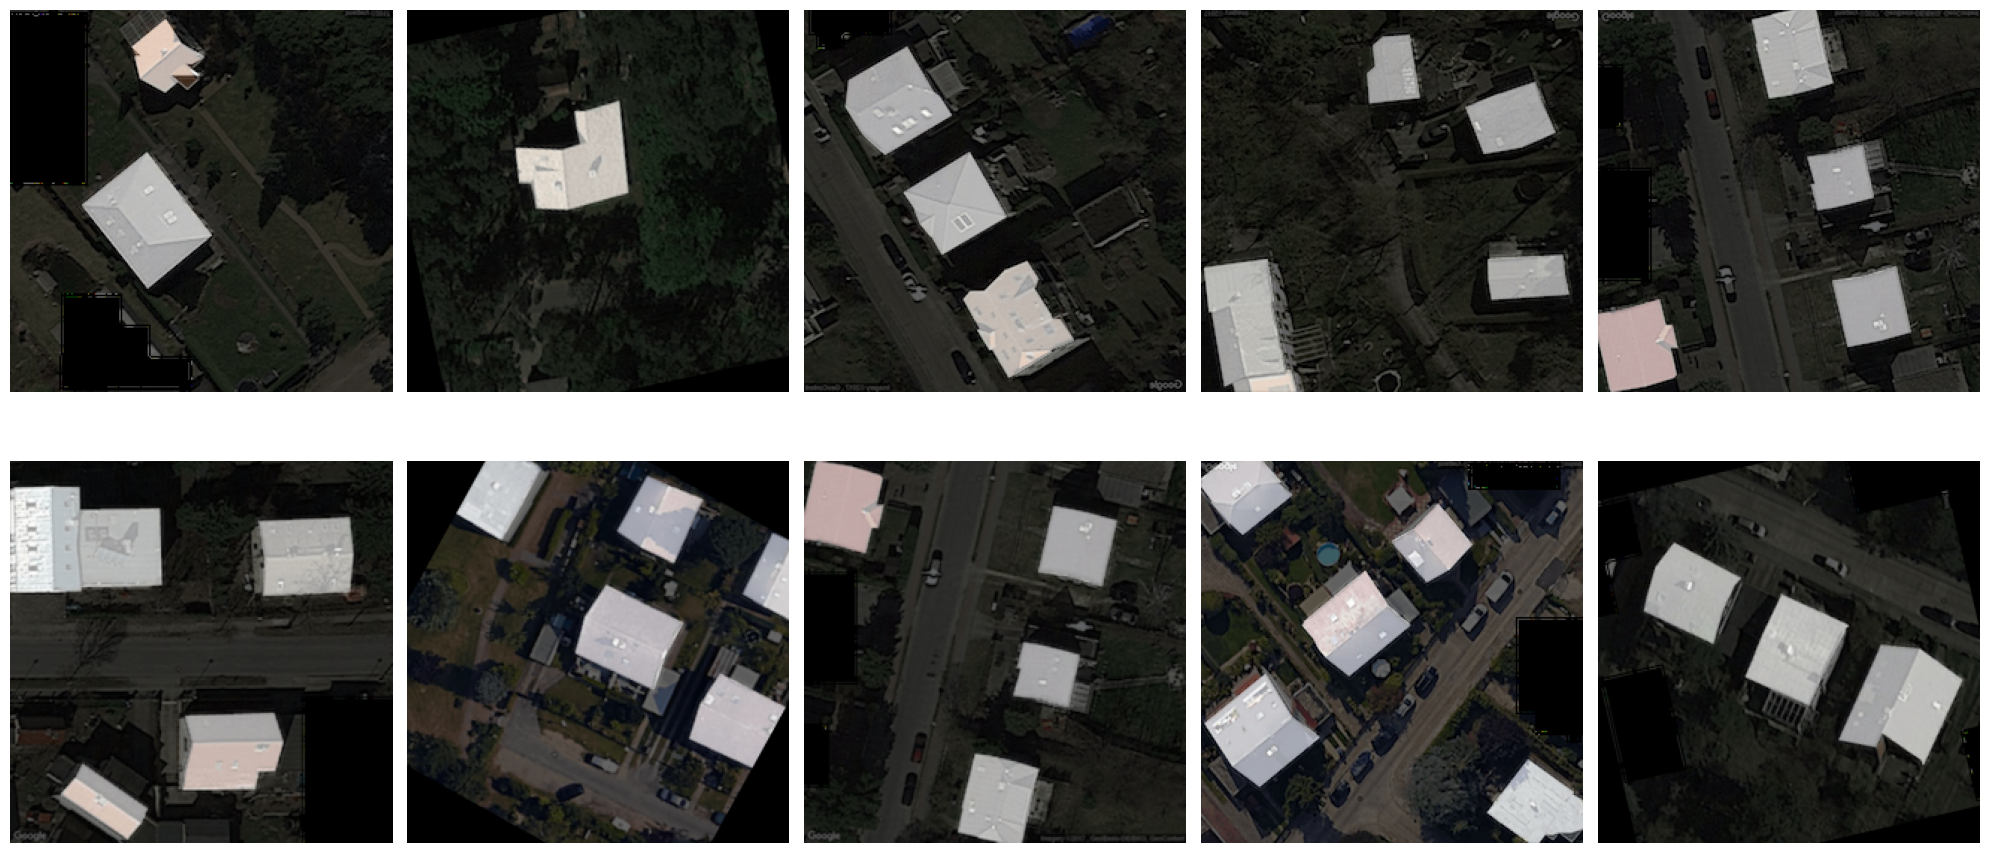

In [ ]:
#Overlapping Original image and Mask and showing smaple ones
plt.figure(figsize=(20,10))
for i in range(10):
    plt.subplot(2,5,i+1)
    id = np.random.randint(len(images))
    image = images[id]
    mask = masks[id]
    show_mask(image, mask)
plt.tight_layout()
plt.show()

#Training

In [ ]:
BATCH_SIZE = 15
SPE = len(train_images)//BATCH_SIZE

In [ ]:
#Creating the model
aunet.fit(
    train_images, train_masks,
    epochs=100,
    batch_size=BATCH_SIZE,
    steps_per_epoch=SPE,
    callbacks=[ModelCheckpoint("AttentionUNet-PersonSegmentation.h5", save_best_only=True)]
)

Epoch 1/100
40/40 [==============================] - ETA: 0s - loss: 0.3533

40/40 [==============================] - 100s 1s/step - loss: 0.3533
Epoch 2/100
40/40 [==============================] - ETA: 0s - loss: 0.2699

40/40 [==============================] - 48s 1s/step - loss: 0.2699
Epoch 3/100
40/40 [==============================] - ETA: 0s - loss: 0.2590

40/40 [==============================] - 47s 1s/step - loss: 0.2590
Epoch 4/100
40/40 [==============================] - ETA: 0s - loss: 0.2461

40/40 [==============================] - 47s 1s/step - loss: 0.2461
Epoch 5/100
40/40 [==============================] - ETA: 0s - loss: 0.2229

40/40 [==============================] - 48s 1s/step - loss: 0.2229
Epoch 6/100
40/40 [==============================] - ETA: 0s - loss: 0.2078

40/40 [==============================] - 47s 1s/step - loss: 0.2078
Epoch 7/100
40/40 [==============================] - ETA: 0s - loss: 0.1937

40/40 [==============================] - 47s 1s/step - loss: 0.1937
Epoch 8/100
40/40 [==============================] - ETA: 0s - loss: 0.1786

40/40 [==============================] - 47s 1s/step - loss: 0.1786
Epoch 9/100
40/40 [==============================] - ETA: 0s - loss: 0.1684

40/40 [==============================] - 47s 1s/step - loss: 0.1684
Epoch 10/100
40/40 [==============================] - ETA: 0s - loss: 0.1553

40/40 [==============================] - 47s 1s/step - loss: 0.1553
Epoch 11/100
40/40 [==============================] - ETA: 0s - loss: 0.1545

40/40 [==============================] - 47s 1s/step - loss: 0.1545
Epoch 12/100
40/40 [==============================] - ETA: 0s - loss: 0.1430

40/40 [==============================] - 47s 1s/step - loss: 0.1430
Epoch 13/100
40/40 [==============================] - ETA: 0s - loss: 0.1334

40/40 [==============================] - 47s 1s/step - loss: 0.1334
Epoch 14/100
40/40 [==============================] - ETA: 0s - loss: 0.1264

40/40 [==============================] - 47s 1s/step - loss: 0.1264
Epoch 15/100
40/40 [==============================] - ETA: 0s - loss: 0.1154

40/40 [==============================] - 47s 1s/step - loss: 0.1154
Epoch 16/100
40/40 [==============================] - ETA: 0s - loss: 0.1094

40/40 [==============================] - 47s 1s/step - loss: 0.1094
Epoch 17/100
40/40 [==============================] - ETA: 0s - loss: 0.1057

40/40 [==============================] - 47s 1s/step - loss: 0.1057
Epoch 18/100
40/40 [==============================] - ETA: 0s - loss: 0.1183

40/40 [==============================] - 47s 1s/step - loss: 0.1183
Epoch 19/100
40/40 [==============================] - ETA: 0s - loss: 0.1016

40/40 [==============================] - 47s 1s/step - loss: 0.1016
Epoch 20/100
40/40 [==============================] - ETA: 0s - loss: 0.0889

40/40 [==============================] - 47s 1s/step - loss: 0.0889
Epoch 21/100
40/40 [==============================] - ETA: 0s - loss: 0.0780

40/40 [==============================] - 47s 1s/step - loss: 0.0780
Epoch 22/100
40/40 [==============================] - ETA: 0s - loss: 0.0723

40/40 [==============================] - 47s 1s/step - loss: 0.0723
Epoch 23/100
40/40 [==============================] - ETA: 0s - loss: 0.0704

40/40 [==============================] - 47s 1s/step - loss: 0.0704
Epoch 24/100
40/40 [==============================] - ETA: 0s - loss: 0.0658

40/40 [==============================] - 47s 1s/step - loss: 0.0658
Epoch 25/100
40/40 [==============================] - ETA: 0s - loss: 0.0765

40/40 [==============================] - 47s 1s/step - loss: 0.0765
Epoch 26/100
40/40 [==============================] - ETA: 0s - loss: 0.0787

40/40 [==============================] - 47s 1s/step - loss: 0.0787
Epoch 27/100
40/40 [==============================] - ETA: 0s - loss: 0.0634

40/40 [==============================] - 47s 1s/step - loss: 0.0634
Epoch 28/100
40/40 [==============================] - ETA: 0s - loss: 0.0514

40/40 [==============================] - 47s 1s/step - loss: 0.0514
Epoch 29/100
40/40 [==============================] - ETA: 0s - loss: 0.0529

40/40 [==============================] - 47s 1s/step - loss: 0.0529
Epoch 30/100
40/40 [==============================] - ETA: 0s - loss: 0.0489

40/40 [==============================] - 47s 1s/step - loss: 0.0489
Epoch 31/100
40/40 [==============================] - ETA: 0s - loss: 0.0453

40/40 [==============================] - 47s 1s/step - loss: 0.0453
Epoch 32/100
40/40 [==============================] - ETA: 0s - loss: 0.0508

40/40 [==============================] - 47s 1s/step - loss: 0.0508
Epoch 33/100
40/40 [==============================] - ETA: 0s - loss: 0.0515

40/40 [==============================] - 47s 1s/step - loss: 0.0515
Epoch 34/100
40/40 [==============================] - ETA: 0s - loss: 0.0596

40/40 [==============================] - 47s 1s/step - loss: 0.0596
Epoch 35/100
40/40 [==============================] - ETA: 0s - loss: 0.0435

40/40 [==============================] - 47s 1s/step - loss: 0.0435
Epoch 36/100
40/40 [==============================] - ETA: 0s - loss: 0.0376

40/40 [==============================] - 47s 1s/step - loss: 0.0376
Epoch 37/100
40/40 [==============================] - ETA: 0s - loss: 0.0348

40/40 [==============================] - 47s 1s/step - loss: 0.0348
Epoch 38/100
40/40 [==============================] - ETA: 0s - loss: 0.0334

40/40 [==============================] - 47s 1s/step - loss: 0.0334
Epoch 39/100
40/40 [==============================] - ETA: 0s - loss: 0.0334

40/40 [==============================] - 47s 1s/step - loss: 0.0334
Epoch 40/100
40/40 [==============================] - ETA: 0s - loss: 0.0350

40/40 [==============================] - 47s 1s/step - loss: 0.0350
Epoch 41/100
40/40 [==============================] - ETA: 0s - loss: 0.0332

40/40 [==============================] - 47s 1s/step - loss: 0.0332
Epoch 42/100
40/40 [==============================] - ETA: 0s - loss: 0.0311

40/40 [==============================] - 47s 1s/step - loss: 0.0311
Epoch 43/100
40/40 [==============================] - ETA: 0s - loss: 0.0299

40/40 [==============================] - 47s 1s/step - loss: 0.0299
Epoch 44/100
40/40 [==============================] - ETA: 0s - loss: 0.0281

40/40 [==============================] - 47s 1s/step - loss: 0.0281
Epoch 45/100
40/40 [==============================] - ETA: 0s - loss: 0.0282

40/40 [==============================] - 47s 1s/step - loss: 0.0282
Epoch 46/100
40/40 [==============================] - ETA: 0s - loss: 0.0271

40/40 [==============================] - 47s 1s/step - loss: 0.0271
Epoch 47/100
40/40 [==============================] - ETA: 0s - loss: 0.0263

40/40 [==============================] - 47s 1s/step - loss: 0.0263
Epoch 48/100
40/40 [==============================] - ETA: 0s - loss: 0.0262

40/40 [==============================] - 47s 1s/step - loss: 0.0262
Epoch 49/100
40/40 [==============================] - ETA: 0s - loss: 0.0259

40/40 [==============================] - 47s 1s/step - loss: 0.0259
Epoch 50/100
40/40 [==============================] - ETA: 0s - loss: 0.0282

40/40 [==============================] - 47s 1s/step - loss: 0.0282
Epoch 51/100
40/40 [==============================] - ETA: 0s - loss: 0.0275

40/40 [==============================] - 47s 1s/step - loss: 0.0275
Epoch 52/100
40/40 [==============================] - ETA: 0s - loss: 0.0258

40/40 [==============================] - 47s 1s/step - loss: 0.0258
Epoch 53/100
40/40 [==============================] - ETA: 0s - loss: 0.0257

40/40 [==============================] - 47s 1s/step - loss: 0.0257
Epoch 54/100
40/40 [==============================] - ETA: 0s - loss: 0.0692

40/40 [==============================] - 47s 1s/step - loss: 0.0692
Epoch 55/100
40/40 [==============================] - ETA: 0s - loss: 0.0490

40/40 [==============================] - 47s 1s/step - loss: 0.0490
Epoch 56/100
40/40 [==============================] - ETA: 0s - loss: 0.0552

40/40 [==============================] - 47s 1s/step - loss: 0.0552
Epoch 57/100
40/40 [==============================] - ETA: 0s - loss: 0.0345

40/40 [==============================] - 47s 1s/step - loss: 0.0345
Epoch 58/100
40/40 [==============================] - ETA: 0s - loss: 0.0287

40/40 [==============================] - 47s 1s/step - loss: 0.0287
Epoch 59/100
40/40 [==============================] - ETA: 0s - loss: 0.0263

40/40 [==============================] - 47s 1s/step - loss: 0.0263
Epoch 60/100
40/40 [==============================] - ETA: 0s - loss: 0.0249

40/40 [==============================] - 47s 1s/step - loss: 0.0249
Epoch 61/100
40/40 [==============================] - ETA: 0s - loss: 0.0239

40/40 [==============================] - 47s 1s/step - loss: 0.0239
Epoch 62/100
40/40 [==============================] - ETA: 0s - loss: 0.0238

40/40 [==============================] - 47s 1s/step - loss: 0.0238
Epoch 63/100
40/40 [==============================] - ETA: 0s - loss: 0.0231

40/40 [==============================] - 47s 1s/step - loss: 0.0231
Epoch 64/100
40/40 [==============================] - ETA: 0s - loss: 0.0227

40/40 [==============================] - 47s 1s/step - loss: 0.0227
Epoch 65/100
40/40 [==============================] - ETA: 0s - loss: 0.0224

40/40 [==============================] - 47s 1s/step - loss: 0.0224
Epoch 66/100
40/40 [==============================] - ETA: 0s - loss: 0.0223

40/40 [==============================] - 47s 1s/step - loss: 0.0223
Epoch 67/100
40/40 [==============================] - ETA: 0s - loss: 0.0219

40/40 [==============================] - 47s 1s/step - loss: 0.0219
Epoch 68/100
40/40 [==============================] - ETA: 0s - loss: 0.0217

40/40 [==============================] - 47s 1s/step - loss: 0.0217
Epoch 69/100
40/40 [==============================] - ETA: 0s - loss: 0.0213

40/40 [==============================] - 47s 1s/step - loss: 0.0213
Epoch 70/100
40/40 [==============================] - ETA: 0s - loss: 0.0213

40/40 [==============================] - 47s 1s/step - loss: 0.0213
Epoch 71/100
40/40 [==============================] - ETA: 0s - loss: 0.0209

40/40 [==============================] - 47s 1s/step - loss: 0.0209
Epoch 72/100
40/40 [==============================] - ETA: 0s - loss: 0.0208

40/40 [==============================] - 47s 1s/step - loss: 0.0208
Epoch 73/100
40/40 [==============================] - ETA: 0s - loss: 0.0206

40/40 [==============================] - 47s 1s/step - loss: 0.0206
Epoch 74/100
40/40 [==============================] - ETA: 0s - loss: 0.0206

40/40 [==============================] - 47s 1s/step - loss: 0.0206
Epoch 75/100
40/40 [==============================] - ETA: 0s - loss: 0.0212

40/40 [==============================] - 47s 1s/step - loss: 0.0212
Epoch 76/100
40/40 [==============================] - ETA: 0s - loss: 0.0207

40/40 [==============================] - 47s 1s/step - loss: 0.0207
Epoch 77/100
40/40 [==============================] - ETA: 0s - loss: 0.0206

40/40 [==============================] - 47s 1s/step - loss: 0.0206
Epoch 78/100
40/40 [==============================] - ETA: 0s - loss: 0.0225

40/40 [==============================] - 47s 1s/step - loss: 0.0225
Epoch 79/100
40/40 [==============================] - ETA: 0s - loss: 0.0216

40/40 [==============================] - 47s 1s/step - loss: 0.0216
Epoch 80/100
40/40 [==============================] - ETA: 0s - loss: 0.0206

40/40 [==============================] - 47s 1s/step - loss: 0.0206
Epoch 81/100
40/40 [==============================] - ETA: 0s - loss: 0.0201

40/40 [==============================] - 47s 1s/step - loss: 0.0201
Epoch 82/100
40/40 [==============================] - ETA: 0s - loss: 0.0198

40/40 [==============================] - 47s 1s/step - loss: 0.0198
Epoch 83/100
40/40 [==============================] - ETA: 0s - loss: 0.0196

40/40 [==============================] - 47s 1s/step - loss: 0.0196
Epoch 84/100
40/40 [==============================] - ETA: 0s - loss: 0.0196

40/40 [==============================] - 47s 1s/step - loss: 0.0196
Epoch 85/100
40/40 [==============================] - ETA: 0s - loss: 0.0194

40/40 [==============================] - 47s 1s/step - loss: 0.0194
Epoch 86/100
40/40 [==============================] - ETA: 0s - loss: 0.0195

40/40 [==============================] - 47s 1s/step - loss: 0.0195
Epoch 87/100
40/40 [==============================] - ETA: 0s - loss: 0.0193

40/40 [==============================] - 47s 1s/step - loss: 0.0193
Epoch 88/100
40/40 [==============================] - ETA: 0s - loss: 0.0193

40/40 [==============================] - 47s 1s/step - loss: 0.0193
Epoch 89/100
40/40 [==============================] - ETA: 0s - loss: 0.0193

40/40 [==============================] - 47s 1s/step - loss: 0.0193
Epoch 90/100
40/40 [==============================] - ETA: 0s - loss: 0.0191

40/40 [==============================] - 47s 1s/step - loss: 0.0191
Epoch 91/100
40/40 [==============================] - ETA: 0s - loss: 0.0189

40/40 [==============================] - 47s 1s/step - loss: 0.0189
Epoch 92/100
40/40 [==============================] - ETA: 0s - loss: 0.0189

40/40 [==============================] - 47s 1s/step - loss: 0.0189
Epoch 93/100
40/40 [==============================] - ETA: 0s - loss: 0.0188

40/40 [==============================] - 47s 1s/step - loss: 0.0188
Epoch 94/100
40/40 [==============================] - ETA: 0s - loss: 0.0189

40/40 [==============================] - 47s 1s/step - loss: 0.0189
Epoch 95/100
40/40 [==============================] - ETA: 0s - loss: 0.0189

40/40 [==============================] - 47s 1s/step - loss: 0.0189
Epoch 96/100
40/40 [==============================] - ETA: 0s - loss: 0.0188

40/40 [==============================] - 47s 1s/step - loss: 0.0188
Epoch 97/100
40/40 [==============================] - ETA: 0s - loss: 0.0187

40/40 [==============================] - 47s 1s/step - loss: 0.0187
Epoch 98/100
40/40 [==============================] - ETA: 0s - loss: 0.0187

40/40 [==============================] - 47s 1s/step - loss: 0.0187
Epoch 99/100
40/40 [==============================] - ETA: 0s - loss: 0.0184

40/40 [==============================] - 47s 1s/step - loss: 0.0184
Epoch 100/100
40/40 [==============================] - ETA: 0s - loss: 0.0184

40/40 [==============================] - 47s 1s/step - loss: 0.0184


In [ ]:

# Define the function for loading and preprocessing the image
def load_image(path):
    return resize(img_to_array(load_img(path))/255.,(256,256))

# Define the function for showing predictions
def show_predictions(model, image_path, n_images=5):
    plt.figure(figsize=(15,8))
        

    image = load_image(image_path)

        # Make the prediction
    pred_mask = model.predict(np.expand_dims(image, axis=0))[0]
    processed_mask = (pred_mask>0.4).astype('float')
        
        # Show the images
    plt.subplot(1,5,1)
    show_image(image, title='Original Image')
        
        
    plt.subplot(1,5,3)
    show_image(pred_mask, title='Predicted Mask')
        
    plt.subplot(1,5,5)
    show_image(processed_mask, title='Processed Mask')
        
    plt.show()


#**Prediction**


1/1 [==============================] - 0s 37ms/step


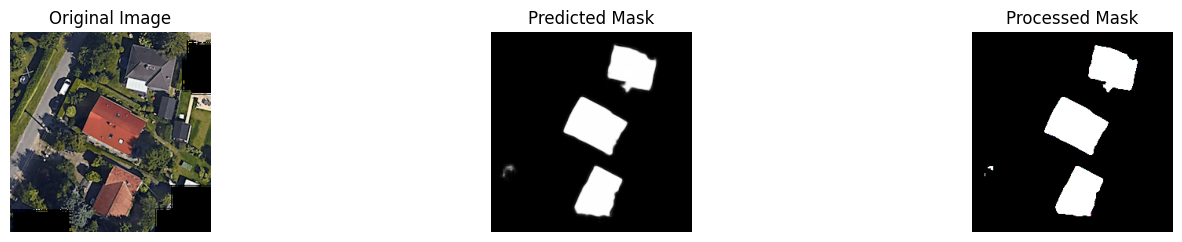

1/1 [==============================] - 0s 31ms/step


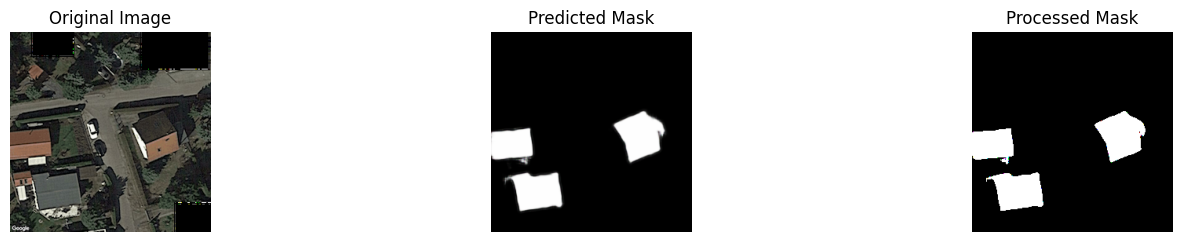

1/1 [==============================] - 0s 33ms/step


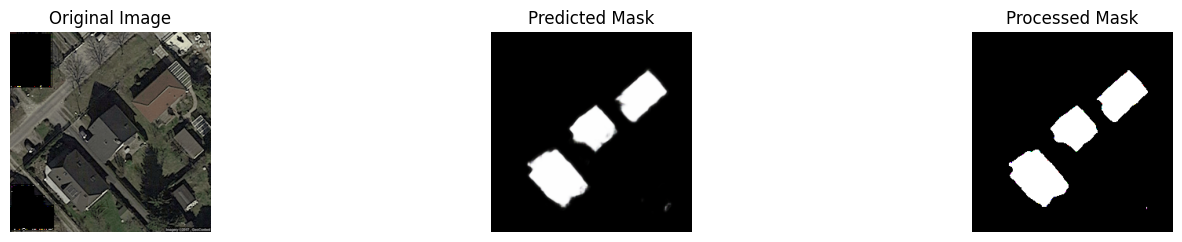

1/1 [==============================] - 0s 27ms/step


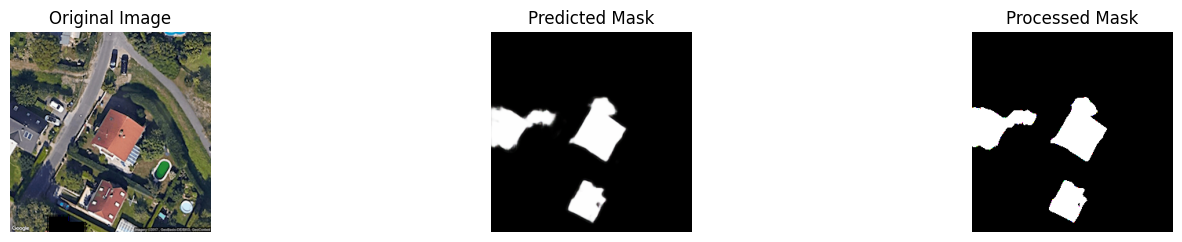

1/1 [==============================] - 0s 27ms/step


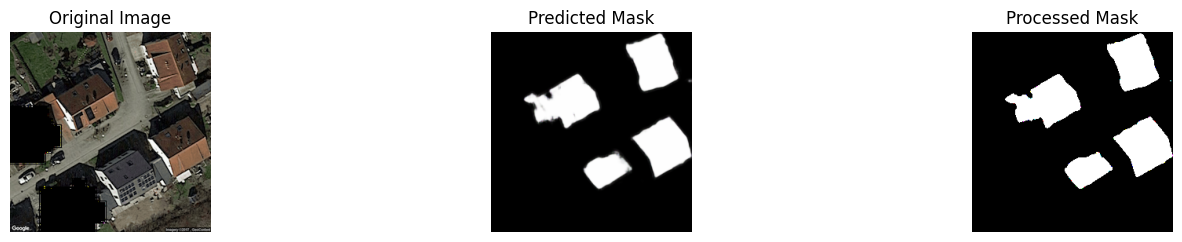

In [ ]:
# Loop through the images in the prediction folder and show the predictions
image_path = r'/content/drive/MyDrive/dida_test_task/predict'
n_images = 5

for dirpath, _, filenames in os.walk(image_path):
    for path_image in filenames:
        image_pred = os.path.abspath(os.path.join(dirpath, path_image))
        show_predictions(aunet, image_pred, n_images)

In [ ]:
#Saving the final model
from tensorflow.keras.models import load_model
aunet.save(r'/content/drive/MyDrive/dida_test_task/my_model.h5')